In [2]:
!pip3 install easydict

  Created wheel for easydict: filename=easydict-1.10-py3-none-any.whl size=6506 sha256=374dfd4a4d1834a7fcd3c453be0f63aadbe5e6602e839b4ca46a142334e426f9
  Stored in directory: /root/.cache/pip/wheels/8d/d6/16/3fd964549d5c27d89d6c5fdb4306283ca55be1799f3d48a67b
Successfully built easydict


In [48]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import easydict
import matplotlib.pyplot as plt
from PIL import Image

from torchvision import datasets
from torchvision import transforms

module_path = os.path.abspath('/ws/external')
if module_path not in sys.path:
    sys.path.append(module_path)
from datasets.builder import build_dataset
from datasets.harddataset import HardDataset
from datasets.mixdataset import BaseDataset, AugMixDataset

config = easydict.EasyDict({
    'batch_size': 1,
    'device': 'cuda',
    'num_classes': 10,
    'resume': '/ws/data/log/cifar10/baselines/augmix_b256_jsdv3_lw12/checkpoint.pth.tar'
})

###############
### Dataset ###
###############
dataset_args = easydict.EasyDict({
    'data_dir': '/ws/data/cifar10',
    'aug': 'augmix',
    'no_jsd': False,
    'all_ops': False,
    'mixture_width': 3,
    'mixture_depth': -1,
    'aug_severity': 3,
    'mixture_coefficient': 1.0,
    'hard_cifar10_dir' : '/ws/data/log/cifar10/baselines/augmix_b256_jsdv3_lw12/false_images',
})


preprocess = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize([0.5]*3, [0.5]*3)])
test_dataset = datasets.CIFAR10(dataset_args.data_dir, train=False, transform=preprocess, download=False)
if dataset_args.aug == 'augmix':
    dataset = AugMixDataset(test_dataset, preprocess, dataset_args.no_jsd,
                            dataset_args.all_ops, dataset_args.mixture_width, 
                            dataset_args.mixture_depth, 
                            dataset_args.aug_severity, 
                            dataset_args.mixture_coefficient)
else:
    dataset = BaseDataset(test_dataset, preprocess, dataset_args.no_jsd)
    
dataset = HardDataset(test_dataset, preprocess, dataset_args.hard_cifar10_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


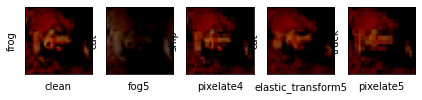

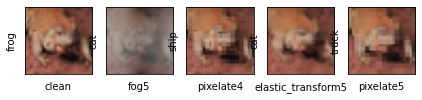

In [33]:
###############
### Dataset ###
###############
from predictor_analysis.utils import visualize, get_images, get_types, get_targets, denormalize

idx = 5

original_images, original_targets, hard_examples = dataset[idx]

images = get_images(original_images, hard_examples)
types = get_types(original_images, hard_examples)
targets = get_targets(original_images, original_targets, hard_examples)

visualize(images, 1, len(images), title='normalized', xlabels=types, ylabels=targets)
visualize(denormalize(images), 1, len(images), title='denormalized', xlabels=types, ylabels=targets)

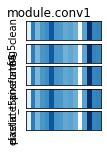

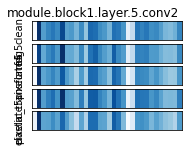

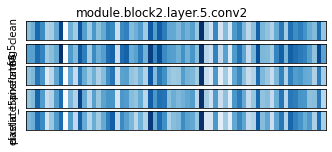

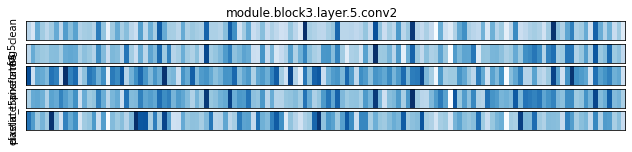

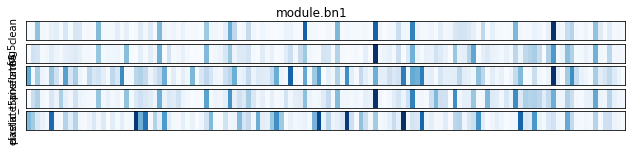

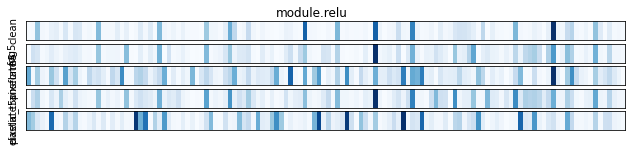

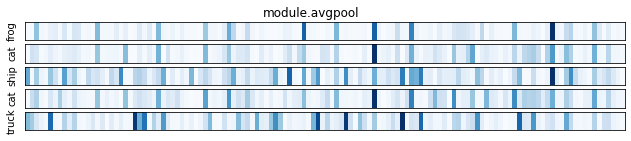

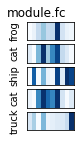

In [61]:
#############
### Model ###
#############
import copy
from models.builder import build_net
from predictor_analysis.utils import get_data, visualize_module_output
from third_party.dscv.utils.param_manager import ParamManager

model_args = easydict.EasyDict({
    'dataset': 'cifar10',
    'additional_loss': 'none',
    'model': 'wrn',
    'layers': 40,
    'widen_factor': 2,
    'droprate': 0.0,
})


model = build_net(model_args, num_classes=config.num_classes)

# Resume
checkpoint = torch.load(config.resume)
model.load_state_dict(checkpoint['state_dict'])

param_manager = ParamManager()
# param_manager.check_param_structure(model)
layer_name_list = ['module.conv1',
                   'module.block1.layer.5.conv2',
                   'module.block2.layer.5.conv2',
                   'module.block3.layer.5.conv2',
                   'module.bn1',
                   'module.relu',
                   'module.avgpool',
                   'module.fc',]
param_manager.register_forward_hook(model, layer_name_list, type='output', detach=True)

### Model
idx = 5
original_images, original_targets, hard_examples = get_data(dataset, idx, config, imshow=False)

hook_results, logits, probs = [], [], []
model.eval()
with torch.no_grad():
    for i in range(len(images)):
        logit = model(images[i].unsqueeze(0))
        prob = F.softmax(logit, dim=-1)

        logits.append(logit.cpu().detach())
        probs.append(prob.cpu().detach())

        results = {'name': types[i],
                   'logit': logit.cpu().detach(),
                   'prob': prob.cpu().detach(),
                   'hook_result': copy.deepcopy(param_manager.hook_results['output'])}
        hook_results.append(results)

for layer_name in layer_name_list:
    if layer_name in ['module.avgpool', 'module.fc']:
        label = targets
    else:
        label = types
    
    visualize_module_output(hook_results, layer_name, ylabels=label)